In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers

from tensorflow.keras.layers import Embedding

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras import optimizers
from tensorflow.keras import losses

# load IMDB dataset
from tensorflow.keras.datasets import imdb

In [2]:
tf.__version__

'2.4.1'

### One hot encoding

Using Keras for word-level one hot encoding

In [3]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

In [4]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)

In [5]:
sequences = tokenizer.texts_to_sequences(samples)

In [6]:
sequences

[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

In [7]:
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

In [8]:
one_hot_results

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [9]:
word_index = tokenizer.word_index

print('found %s unique tokens' % len(word_index))

found 9 unique tokens


### Word Embedding

Loading the IMDB data for use with an Embedding layer

In [10]:
max_features = 10000
max_len = 20

In [11]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/sidparmar/opt/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/sidparmar/opt/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) i

In [12]:
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

In [13]:
embedding_layer = Embedding(1000, 64)

In [14]:
model = models.Sequential()

model.add(Embedding(10000, 8, input_length=max_len))

model.add(layers.Flatten())

model.add(layers.Dense(1, activation="sigmoid"))

In [15]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [16]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6890 - acc: 0.5387 - val_loss: 0.6393 - val_acc: 0.6904
Epoch 2/10
625/625 [==============================] - 1s 841us/step - loss: 0.5919 - acc: 0.7376 - val_loss: 0.5341 - val_acc: 0.7268
Epoch 3/10
625/625 [==============================] - 0s 772us/step - loss: 0.4811 - acc: 0.7797 - val_loss: 0.5024 - val_acc: 0.7458
Epoch 4/10
625/625 [==============================] - 0s 754us/step - loss: 0.4309 - acc: 0.8089 - val_loss: 0.4944 - val_acc: 0.7516
Epoch 5/10
625/625 [==============================] - 0s 752us/step - loss: 0.3958 - acc: 0.8214 - val_loss: 0.4935 - val_acc: 0.7550
Epoch 6/10
625/625 [==============================] - 0s 744us/step - loss: 0.3762 - acc: 0.8369 - val_loss: 0.4959 - val_acc: 0.7566
Epoch 7/10
625/625 [==============================] - 1s 861us/step - loss: 0.3538 - acc: 0.8486 - val_loss: 0.5026 - val_acc: 0.7560
Epoch 8/10
625/625 [==============================] - 1s 894us/s

74% validation accuracy with just 20 words per review. That's great.

But note that merely flattening the embedded sequences and training a single Dense layer on top leads to a model that treats each word in the input sequence separately, without considering inter-word relationships and sentence structure (for example, this model would likely treat both “this movie is a bomb” and “this movie is the bomb” as being negative reviews). It’s much better to add recurrent layers or 1D convolutional layers on top of the embedded sequences to learn features that take into account each sequence as a whole. 

### from raw text to word embeddings

Processing the labels of the raw IMDB data

In [17]:
imdb_dir = '/Users/sidparmar/workspace-ml/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

In [18]:
labels = []
texts = []

In [19]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            
            if label_type == 'neg':
                labels.append(0)
                
            else:
                labels.append(1)            

### Tokenizing the data

In [20]:
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

In [21]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [22]:
word_index = tokenizer.word_index
print("Unique words", len(word_index))

Unique words 88582


In [23]:
data = pad_sequences(sequences, maxlen=maxlen)

In [24]:
labels = np.asarray(labels)
print('Shape of data tensor', data.shape)
print('Shape of label tensor', labels.shape)

Shape of data tensor (25000, 100)
Shape of label tensor (25000,)


In [25]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [26]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

#### Preprocessing the embeddings

In [27]:
glove_dir = '/Users/sidparmar/workspace-ml/'

In [28]:
embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.42B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

In [29]:
print('Founds %s words vecrtor' % len(embedding_index))

Founds 1917494 words vecrtor


Next, you’ll build an embedding matrix that you can load into an Embedding layer. 

In [30]:
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))

In [31]:
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### Build model

In [32]:
model = models.Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                960032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,960,065
Trainable params: 3,960,065
Non-trainable params: 0
_________________________________________________________________


Loading the GloVe embeddings in the model

In [33]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Compile and train

In [34]:
model.compile(optimizer=optimizers.RMSprop(), 
              loss=losses.binary_crossentropy, 
              metrics=['acc'])

In [35]:
history = model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 74ms/step - loss: 1.5930 - acc: 0.5398 - val_loss: 0.6844 - val_acc: 0.5621
Epoch 2/10
7/7 [==============================] - 0s 57ms/step - loss: 0.3687 - acc: 0.8529 - val_loss: 0.7197 - val_acc: 0.5306
Epoch 3/10
7/7 [==============================] - 0s 57ms/step - loss: 0.2074 - acc: 0.9730 - val_loss: 0.6844 - val_acc: 0.5728
Epoch 4/10
7/7 [==============================] - 0s 57ms/step - loss: 0.0947 - acc: 1.0000 - val_loss: 0.9152 - val_acc: 0.5066
Epoch 5/10
7/7 [==============================] - 0s 67ms/step - loss: 0.0647 - acc: 1.0000 - val_loss: 0.6968 - val_acc: 0.5767
Epoch 6/10
7/7 [==============================] - 0s 75ms/step - loss: 0.0262 - acc: 1.0000 - val_loss: 0.9161 - val_acc: 0.5228
Epoch 7/10
7/7 [==============================] - 0s 75ms/step - loss: 0.0170 - acc: 1.0000 - val_loss: 0.8054 - val_acc: 0.5632
Epoch 8/10
7/7 [==============================] - 0s 72ms/step - loss: 0.0096 - acc: 1.0000 - val

Plot loss and accuracy

In [36]:
def plot_loss(loss, val_loss, epochs):
    plt.plot(epochs, loss, 'bo', label="Training Loss")
    plt.plot(epochs, val_loss, 'b', label="Validation Loss")
    
    
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [37]:
def plot_acc(acc, val_acc, epochs):
    plt.plot(epochs, acc, 'bo', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
    
    
    plt.title('Training and validation Accuracy')
    plt.legend()

    plt.show()

In [38]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

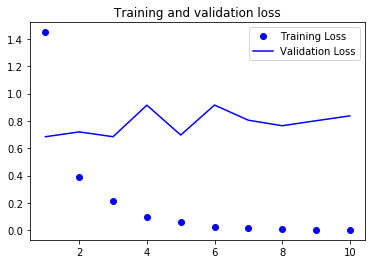

In [39]:
plot_loss(loss, val_loss, epochs)

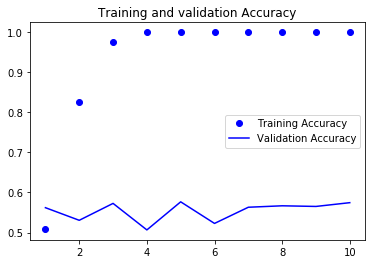

In [40]:
plot_acc(acc, val_acc, epochs)

The model quickly starts overfitting, which is unsurprising given the small number of training samples. Validation accuracy has high variance for the same reason, but it seems to reach the high 50s.

Let's try building a model with out pretrained embedding data. Just 200 samples from training. 

In [41]:
model_without_pre_training = models.Sequential()
model_without_pre_training.add(layers.Embedding(max_words, 100, input_length=maxlen))
model_without_pre_training.add(layers.Flatten())
model_without_pre_training.add(layers.Dense(32, activation='relu'))
model_without_pre_training.add(layers.Dense(1, activation='sigmoid'))
model_without_pre_training.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [42]:
model_without_pre_training.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history_without_pretrained_embedding_data = model_without_pre_training.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 1s 67ms/step - loss: 0.6956 - acc: 0.5109 - val_loss: 0.6978 - val_acc: 0.5015
Epoch 2/10
7/7 [==============================] - 0s 54ms/step - loss: 0.5112 - acc: 0.9645 - val_loss: 0.7158 - val_acc: 0.5062
Epoch 3/10
7/7 [==============================] - 0s 42ms/step - loss: 0.2925 - acc: 0.9743 - val_loss: 0.7319 - val_acc: 0.5070
Epoch 4/10
7/7 [==============================] - 0s 42ms/step - loss: 0.1333 - acc: 0.9892 - val_loss: 0.7061 - val_acc: 0.5194
Epoch 5/10
7/7 [==============================] - 0s 52ms/step - loss: 0.0601 - acc: 1.0000 - val_loss: 0.7058 - val_acc: 0.5293
Epoch 6/10
7/7 [==============================] - 0s 51ms/step - loss: 0.0308 - acc: 1.0000 - val_loss: 0.7115 - val_acc: 0.5292
Epoch 7/10
7/7 [==============================] - 0s 43ms/step - loss: 0.0172 - acc: 1.0000 - val_loss: 0.7231 - val_acc: 0.5254
Epoch 8/10
7/7 [==============================] - 0s 53ms/step - loss: 0.0095 - acc: 1.0000 - val

In [43]:
acc = history_without_pretrained_embedding_data.history['acc']
val_acc = history_without_pretrained_embedding_data.history['val_acc']

loss = history_without_pretrained_embedding_data.history['loss']
val_loss = history_without_pretrained_embedding_data.history['val_loss']

epochs = range(1, len(acc) + 1)

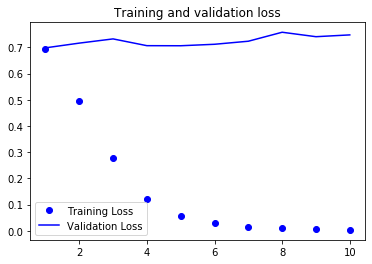

In [44]:
plot_loss(loss, val_loss, epochs)

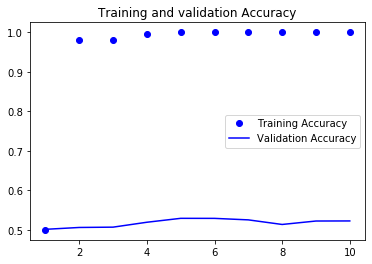

In [45]:
plot_acc(acc, val_acc, epochs)

The model is severely overfitting

#### let’s evaluate the model on the test data. 

Tokenizing the data of the test set

In [46]:
test_dir = os.path.join(imdb_dir, 'test')

In [47]:
labels = []
texts = []

In [48]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [49]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [50]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 1ms/step - loss: 0.8366 - acc: 0.5707


[0.836603045463562, 0.5707200169563293]

Got 56% accuracy working with just 200 samples. 

Adding more samples can decrease overfitting and increase accuracy.

# RNN

In [51]:
tf.keras.backend.clear_session()

Pre processing data

In [52]:
max_features = 10000
maxlen = 500
batch_size = 32

In [53]:
print('Loading Data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

print(len(input_train), 'train sequence')
print(len(input_test), 'test sequence')

Loading Data...


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/sidparmar/opt/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


25000 train sequence
25000 test sequence


/Users/sidparmar/opt/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [54]:
print('Pad sequences (samples X times)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)

print('input_train shape', input_train.shape)
print('input_test shape', input_test.shape)

Pad sequences (samples X times)
input_train shape (25000, 500)
input_test shape (25000, 500)


### SimpleRNN

In [55]:
model_with_simple_RNN = models.Sequential()
model_with_simple_RNN.add(layers.Embedding(max_features, 32))
model_with_simple_RNN.add(layers.SimpleRNN(32))
model_with_simple_RNN.add(layers.Dense(1, activation='sigmoid'))

In [56]:
model_with_simple_RNN.compile(loss=losses.binary_crossentropy, 
                              optimizer=optimizers.RMSprop(), 
                              metrics=['acc'])

In [57]:
history_with_simple_RNN = model_with_simple_RNN.fit(input_train, y_train, 
                                                    epochs=10, 
                                                    batch_size=128, 
                                                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 15s 88ms/step - loss: 0.6752 - acc: 0.5620 - val_loss: 0.5054 - val_acc: 0.7804
Epoch 2/10
157/157 [==============================] - 13s 85ms/step - loss: 0.4006 - acc: 0.8347 - val_loss: 0.4570 - val_acc: 0.8156
Epoch 3/10
157/157 [==============================] - 13s 85ms/step - loss: 0.2957 - acc: 0.8832 - val_loss: 0.3327 - val_acc: 0.8662
Epoch 4/10
157/157 [==============================] - 14s 89ms/step - loss: 0.2242 - acc: 0.9159 - val_loss: 0.3427 - val_acc: 0.8548
Epoch 5/10
157/157 [==============================] - 14s 89ms/step - loss: 0.1902 - acc: 0.9322 - val_loss: 0.3448 - val_acc: 0.8666
Epoch 6/10
157/157 [==============================] - 13s 84ms/step - loss: 0.1354 - acc: 0.9549 - val_loss: 0.3748 - val_acc: 0.8636
Epoch 7/10
157/157 [==============================] - 13s 84ms/step - loss: 0.1054 - acc: 0.9634 - val_loss: 0.3901 - val_acc: 0.8742
Epoch 8/10
157/157 [==============================] - 13s 84ms

In [58]:
acc = history_with_simple_RNN.history['acc']
val_acc = history_with_simple_RNN.history['val_acc']

loss = history_with_simple_RNN.history['loss']
val_loss = history_with_simple_RNN.history['val_loss']

epochs = range(1, len(acc) + 1)

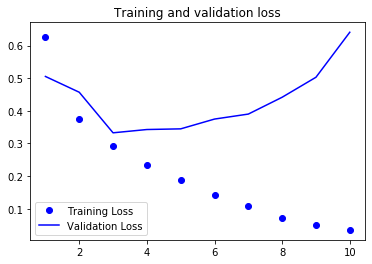

In [59]:
plot_loss(loss, val_loss, epochs)

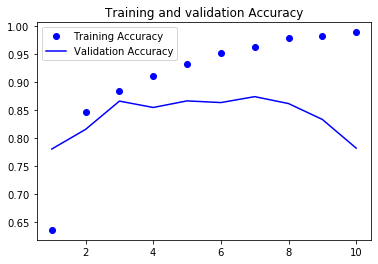

In [60]:
plot_acc(acc, val_acc, epochs)

As a reminder, in chapter 3, the first naive approach to this dataset got you to a test accuracy of 88%. Unfortunately, this small recurrent network doesn’t perform well compared to this baseline (only 82% validation accuracy). Part of the problem is that your inputs only consider the first 500 words, rather than full sequences—hence, the RNN has access to less information than the earlier baseline model. The remainder of the problem is that SimpleRNN isn’t good at processing long sequences, such as text. Other types of recurrent layers perform much better. 

### LSTM

In [61]:
model_with_LSTM = models.Sequential()
model_with_LSTM.add(layers.Embedding(max_features, 32))
model_with_LSTM.add(layers.LSTM(32))
model_with_LSTM.add(layers.Dense(1, activation="sigmoid"))

In [62]:
model_with_LSTM.compile(loss=losses.binary_crossentropy, 
                        optimizer=optimizers.RMSprop(), 
                        metrics=['acc'])

In [63]:
history_with_LSTM = model_with_LSTM.fit(input_train, y_train, 
                                        epochs=10, 
                                        batch_size=128, 
                                        validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 26s 160ms/step - loss: 0.6109 - acc: 0.6730 - val_loss: 0.3586 - val_acc: 0.8586
Epoch 2/10
157/157 [==============================] - 22s 143ms/step - loss: 0.2923 - acc: 0.8889 - val_loss: 0.2899 - val_acc: 0.8848
Epoch 3/10
157/157 [==============================] - 22s 142ms/step - loss: 0.2327 - acc: 0.9134 - val_loss: 0.6563 - val_acc: 0.7726
Epoch 4/10
157/157 [==============================] - 22s 143ms/step - loss: 0.2114 - acc: 0.9256 - val_loss: 0.3542 - val_acc: 0.8812
Epoch 5/10
157/157 [==============================] - 23s 145ms/step - loss: 0.1742 - acc: 0.9370 - val_loss: 0.3512 - val_acc: 0.8726
Epoch 6/10
157/157 [==============================] - 23s 147ms/step - loss: 0.1515 - acc: 0.9475 - val_loss: 0.2952 - val_acc: 0.8826
Epoch 7/10
157/157 [==============================] - 23s 144ms/step - loss: 0.1334 - acc: 0.9528 - val_loss: 0.3395 - val_acc: 0.8844
Epoch 8/10
157/157 [==============================] - 2

In [64]:
acc = history_with_LSTM.history['acc']
val_acc = history_with_LSTM.history['val_acc']

loss = history_with_LSTM.history['loss']
val_loss = history_with_LSTM.history['val_loss']

epochs = range(1, len(acc) + 1)

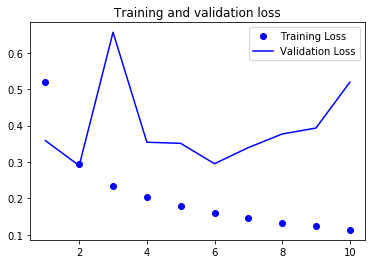

In [65]:
plot_loss(loss, val_loss, epochs)

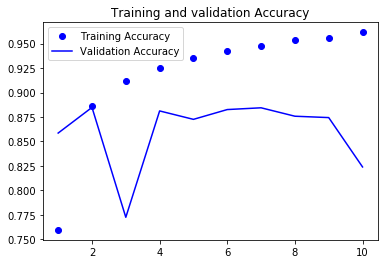

In [66]:
plot_acc(acc, val_acc, epochs)

This time, you achieve up to ~88% validation accuracy. Not bad: certainly much better than the SimpleRNN network—that’s largely because LSTM suffers much less from the vanishing-gradient problem—and slightly better than the fully connected approach from chapter 3, even though you’re looking at less data than you were in chapter 3. You’re truncating sequences after 500 timesteps, whereas in chapter 3, you were considering full sequences.

# Jenna Climate - Weather Model

In [67]:
data_dir = '/Users/sidparmar/workspace-ml/deep-learning-with-python/jena_climate'
f_name = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [68]:
f = open(f_name)
data = f.read()
f.close()

In [69]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [70]:
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [71]:
len(lines)

420451

Now convert all 420,451 lines into a numpy array

In [72]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### Temp graph

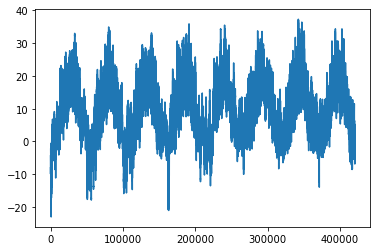

In [73]:
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

Here is the same plot for only first 10 days. Since the data is recorded every 10 mins, we have 144 data points per day.

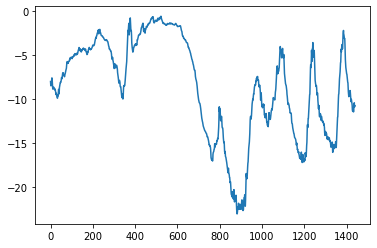

In [74]:
plt.plot(range(1440), temp[:1440])

The exact formulation of the problem will be as follows: given data going as far back as lookback timesteps (a timestep is 10 minutes) and sampled every steps timesteps, can you predict the temperature in delay timesteps? You’ll use the following parameter values:

- lookback = 720—Observations will go back 5 days.
- steps = 6—Observations will be sampled at one data point per hour.
- delay = 144—Targets will be 24 hours in the future.


### Preparing Data

Let's normalize training data - first 200,000 samples

In [75]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

This is the data generator you’ll use. It yields a tuple (samples, targets), where samples is one batch of input data and targets is the corresponding array of target temperatures. It takes the following arguments:

- data—The original array of floating-point data, which you normalized above.
- lookback—How many timesteps back the input data should go.
- delay—How many timesteps in the future the target should be.
- min_index and max_index—Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.
- shuffle—Whether to shuffle the samples or draw them in chronological order.
- batch_size—The number of samples per batch.
- step—The period, in timesteps, at which you sample data. You’ll set it to 6 in order to draw one data point every hour.

In [76]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Preparing the training, validation, and test generators

In [77]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)

test_steps = (len(float_data) - 300001 - lookback)

###  Computing the common-sense baseline MAE

In [78]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [79]:
evaluate_naive_method()

0.28969941979609765


This yields an MAE of 0.29. Because the temperature data has been normalized to be centered on 0 and have a standard deviation of 1, this number isn’t immediately interpretable. It translates to an average absolute error of 0.29 × temperature_std degrees Celsius: 2.57°C.

####  A basic machine-learning approach

In [80]:
dense_weather_model = models.Sequential()
dense_weather_model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
dense_weather_model.add(layers.Dense(32, activation="relu"))
dense_weather_model.add(layers.Dense(1))

In [81]:
dense_weather_model.compile(loss=losses.mae, optimizer=optimizers.RMSprop())

In [82]:
dense_weather_history = dense_weather_model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 662s 1s/step - loss: 1.9986 - val_loss: 1.1156
Epoch 2/20
500/500 [==============================] - 655s 1s/step - loss: 0.6367 - val_loss: 0.3980
Epoch 3/20
500/500 [==============================] - 569s 1s/step - loss: 0.3306 - val_loss: 0.3626
Epoch 4/20
500/500 [==============================] - 599s 1s/step - loss: 0.2779 - val_loss: 0.3126
Epoch 5/20
500/500 [==============================] - 570s 1s/step - loss: 0.2573 - val_loss: 0.3281
Epoch 6/20
500/500 [==============================] - 571s 1s/step - loss: 0.2484 - val_loss: 0.3119
Epoch 7/20
500/500 [==============================] - 572s 1s/step - loss: 0.2421 - val_loss: 0.3065
Epoch 8/20
500/500 [==============================] - 5622s 11s/step - loss: 0.2372 - val_loss: 0.3340
Epoch 9/20
500/500 [==============================] - 639s 1s/step - loss: 0.2293 - val_loss: 0.3052
Epoch 10/20
500/500 [==============================] - 691s 1s/step - loss: 0.2273 - val_

In [85]:
loss = dense_weather_history.history['loss']
val_loss = dense_weather_history.history['val_loss']

epochs = range(1, len(loss) + 1)

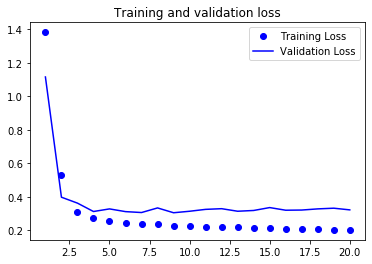

In [86]:
plot_loss(loss, val_loss, epochs)

Validation loss is higher than base line loss. That just means that this network learned nothing.

#### First RNN baseline

In [87]:
rnn_baseline_model = models.Sequential()
rnn_baseline_model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
rnn_baseline_model.add(layers.Dense(1))

In [88]:
rnn_baseline_model.compile(loss=losses.mae, optimizer=optimizers.RMSprop())

In [89]:
history_rnn_baseline = rnn_baseline_model.fit(train_gen, 
                                              steps_per_epoch=500, 
                                              epochs=20, 
                                              validation_data=val_gen, 
                                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 1469s 3s/step - loss: 0.3188 - val_loss: 0.2692
Epoch 2/20
500/500 [==============================] - 1486s 3s/step - loss: 0.2851 - val_loss: 0.2649
Epoch 3/20
500/500 [==============================] - 1464s 3s/step - loss: 0.2780 - val_loss: 0.2698
Epoch 4/20
500/500 [==============================] - 1458s 3s/step - loss: 0.2706 - val_loss: 0.2647
Epoch 5/20
500/500 [==============================] - 1441s 3s/step - loss: 0.2664 - val_loss: 0.2691
Epoch 6/20
500/500 [==============================] - 1439s 3s/step - loss: 0.2636 - val_loss: 0.2688
Epoch 7/20
500/500 [==============================] - 1447s 3s/step - loss: 0.2566 - val_loss: 0.2766
Epoch 8/20
500/500 [==============================] - 1466s 3s/step - loss: 0.2511 - val_loss: 0.2735
Epoch 9/20
500/500 [==============================] - 1447s 3s/step - loss: 0.2487 - val_loss: 0.2732
Epoch 10/20
500/500 [==============================] - 1456s 3s/step - loss: 0.245

In [90]:
loss = history_rnn_baseline.history['loss']
val_loss = history_rnn_baseline.history['val_loss']

epochs = range(1, len(loss) + 1)

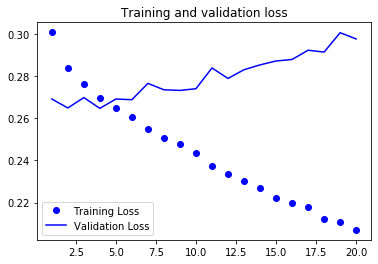

In [91]:
plot_loss(loss, val_loss, epochs)

This model is overfitting. But in the beginning it did better than the dense model and simple baseline. 

There is bit margin of improvement. 

#### Using recurrent dropout to fight overfitting

In [92]:
model_rnn_dropout = models.Sequential()
model_rnn_dropout.add(layers.GRU(32, 
                                 dropout=0.2, 
                                 recurrent_dropout=0.2, 
                                 input_shape=(None, float_data.shape[-1])))
model_rnn_dropout.add(layers.Dense(1))

In [93]:
model_rnn_dropout.compile(optimizer=optimizers.RMSprop(), loss=losses.mae)

In [94]:
history_rnn_dropout = model_rnn_dropout.fit(train_gen, 
                                            steps_per_epoch=500, 
                                            epochs=40, 
                                            validation_data=val_gen, 
                                            validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 1625s 3s/step - loss: 0.3715 - val_loss: 0.3067
Epoch 2/40
500/500 [==============================] - 1631s 3s/step - loss: 0.3086 - val_loss: 0.2770
Epoch 3/40
500/500 [==============================] - 1610s 3s/step - loss: 0.2989 - val_loss: 0.2704
Epoch 4/40
500/500 [==============================] - 1609s 3s/step - loss: 0.2968 - val_loss: 0.2740
Epoch 5/40
500/500 [==============================] - 1649s 3s/step - loss: 0.2927 - val_loss: 0.2720
Epoch 6/40
500/500 [==============================] - 1647s 3s/step - loss: 0.2903 - val_loss: 0.2673
Epoch 7/40
500/500 [==============================] - 1648s 3s/step - loss: 0.2860 - val_loss: 0.2695
Epoch 8/40
500/500 [==============================] - 1640s 3s/step - loss: 0.2819 - val_loss: 0.2688
Epoch 9/40
500/500 [==============================] - 1639s 3s/step - loss: 0.2825 - val_loss: 0.2682
Epoch 10/40
500/500 [==============================] - 1638s 3s/step - loss: 0.276

In [95]:
loss = history_rnn_dropout.history['loss']
val_loss = history_rnn_dropout.history['val_loss']

epochs = range(1, len(loss) + 1)

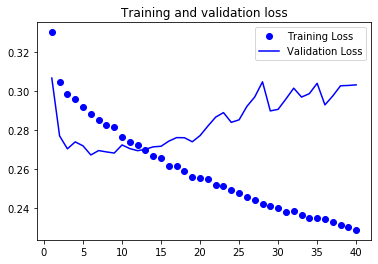

In [96]:
plot_loss(loss, val_loss, epochs)

It is still overfitting severly